<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/images/synthetic_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for classification problems with expectation of probabilities as outcome of the predcition.
- The Y labels are one-hot encoded.
- The loss function is CrossEntropyLoss which will have a log function ( bad prediction has high loss )

In [13]:
import numpy as np
from PIL import Image, ImageDraw

def draw_shape(shape, size=20):
    img = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(img)

    if shape == "circle":
        draw.ellipse([4, 4, size - 4, size - 4], fill=255)

    elif shape == "triangle":
        triangle = [(size // 2, 2), (2, size - 2), (size - 2, size - 2)]
        draw.polygon(triangle, fill=255)

    elif shape == "square":
        draw.rectangle([4, 4, size - 4, size - 4], fill=255)

    elif shape == "star":
        # 5-point star, hand-coded relative to 20x20
        star = [
            (10, 2), (12, 7), (18, 7),
            (13.5, 11.5), (15.5, 18),
            (10, 14.5), (4.5, 18),
            (6.5, 11.5), (2, 7),
            (8, 7)
        ]
        draw.polygon(star, fill=255)

    # flatten the array to be ready for the NN inputs.
    return np.array(img).flatten()

# Shape types and labels
shapes = [("circle", 0), ("triangle", 1), ("square", 2), ("star", 3)]

# Generate data
X = []
Y = []

for shape, label in shapes:
    for _ in range(100):
        X.append(draw_shape(shape))
        Y.append(label)

X = np.array(X)

# One-hot encoding for labels
num_classes = 4

# Converts labels into one-hot encoding
Y_onehot = np.eye(num_classes)[Y]

print("X shape:", X.shape)  # (400, 400)
print("Y shape:", Y_onehot.shape)  # (400, 4), one-hot encoded labels


X shape: (400, 400)
Y shape: (400, 4)


Display the shapes.

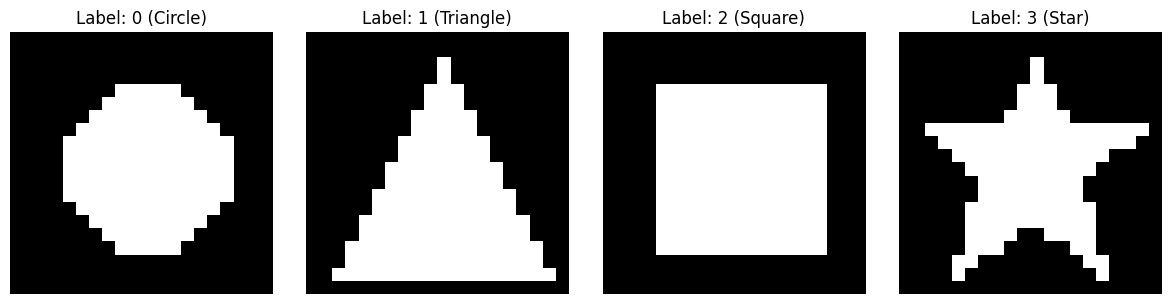

In [14]:
import matplotlib.pyplot as plt

# Display four sample images (one per class)
plt.figure(figsize=(12, 3))

# Sample circle
plt.subplot(1, 4, 1)
plt.imshow(X[0].reshape(20, 20), cmap='gray')
plt.title(f"Label: {Y[0]} (Circle)")
plt.axis('off')

# Sample triangle
plt.subplot(1, 4, 2)
plt.imshow(X[100].reshape(20, 20), cmap='gray')
plt.title(f"Label: {Y[100]} (Triangle)")
plt.axis('off')

# Sample square
plt.subplot(1, 4, 3)
plt.imshow(X[200].reshape(20, 20), cmap='gray')
plt.title(f"Label: {Y[200]} (Square)")
plt.axis('off')

# Sample star
plt.subplot(1, 4, 4)
plt.imshow(X[300].reshape(20, 20), cmap='gray')
plt.title(f"Label: {Y[300]} (Star)")
plt.axis('off')

plt.tight_layout()
plt.show()


Neural network with the following layers.
- A fully connected layer
- Activation ReLU
- A fully connected layer with output size

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)  # output raw logits
        return out

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.long)  # Use long for CrossEntropyLoss

# Create a dataset and dataloader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
hidden_size = 64
output_size = 4

model = FeedforwardNN(input_size, hidden_size, output_size)

# For multi-class classification
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(dataloader):
        outputs = model(inputs)
        # labels are now integers, not one-hot
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training finished.")


Epoch [1/10], Loss: 0.0000
Epoch [2/10], Loss: 0.0000
Epoch [3/10], Loss: 0.0000
Epoch [4/10], Loss: 0.0000
Epoch [5/10], Loss: 0.0000
Epoch [6/10], Loss: 0.0000
Epoch [7/10], Loss: 0.0000
Epoch [8/10], Loss: 0.0000
Epoch [9/10], Loss: 0.0000
Epoch [10/10], Loss: 0.0000
Training finished.


Sample Index: 15
True Label: 0
Predicted Probabilities: tensor([[1.0000e+00, 2.3682e-43, 9.7848e-40, 1.6594e-35]])
Predicted Class: 0


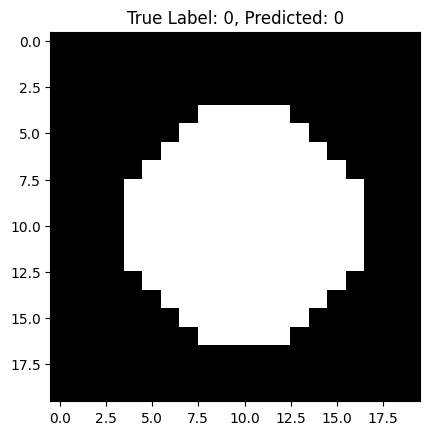

Logits: tensor([[92.8109, -5.3407,  2.9883, 12.7269]])


In [16]:
# Generate a sample for prediction
sample_index = 15
sample_image = X[sample_index]
sample_label = Y[sample_index]

# Convert the sample to a tensor
sample_tensor = torch.tensor(sample_image, dtype=torch.float32).reshape(1,-1)

# Make a prediction
with torch.no_grad():
    output = model(sample_tensor)

# Get the predicted probability and class
# Apply softmax to get probabilities
predicted_probabilities = torch.softmax(output, dim=1)

# Get the class with highest probability
predicted_class = predicted_probabilities.argmax().item()

# Display the results
print(f"Sample Index: {sample_index}")
print(f"True Label: {sample_label}")
print(f"Predicted Probabilities: {predicted_probabilities}")
print(f"Predicted Class: {predicted_class}")

# Display the sample image
plt.imshow(sample_image.reshape(20, 20), cmap="gray")
plt.title(f"True Label: {sample_label}, Predicted: {predicted_class}")
plt.show()


# Get the logits before the sigmoid activation
with torch.no_grad():
    logits = model.fc2(model.relu(model.fc1(sample_tensor)))
    print("Logits:", logits)
